# Testing out Turing.jl and my model using ModelingToolkit
Following [demo code](https://turing.ml/dev/tutorials/10-bayesian-differential-equations/) examples but convertted to use [ModelingToolkit.jl](https://github.com/SciML/ModelingToolkit.jl).

This notebook follows on from ```37_LV_demo_mtoolkit.ipynb```

In [89]:
using Turing
using DifferentialEquations, ModelingToolkit

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Used for discarding warnings
using Logging: with_logger, NullLogger

# Set a seed for reproducibility.
using Random
Random.seed!(13);

## ModelingToolkit.jl setup
This creates and ODESystem using ModelingToolkit (MT) and then simplifies it.

In [90]:
mtp = @parameters k_TX k_TL k_RS k_EN k_nt_deg k_TL_deg K_TX_DNA K_TX_NTP K_TL_nt K_TL_AT K_TL_NTP K_RS_A K_RS_T K_RS_NTP K_EN_CP K_EN_NXP

@variables t NTP(t) NXP(t) nt(t) Ppi(t) AT(t) a(t) T(t) A(t) CP(t) C(t)
@variables C_TXcat(t) C_TLcat(t) C_RScat(t) C_ENcat(t) C_DNA(t)
@variables V_TX(t) V_TL(t) V_RS(t) V_EN(t)

x_o_vars = ["nt", "a"]

n_A = 20
n_T = 46
n_NTP = 4
c_avg_tRNA_aa = (n_T / n_A)

D = Differential(t)

function MM(c, K)
    return(c/(K+c))
end

@variables phi_total(t), phi_TX(t), phi_TL(t), phi_RS(t)

eqs = [V_TX ~ (k_TX * C_TXcat
               * MM(C_DNA, K_TX_DNA)
               * MM(NTP, K_TX_NTP)),
       V_TL ~ (k_TL * C_TLcat * MM(nt, K_TL_nt)
               * MM(c_avg_tRNA_aa * AT, K_TL_AT)
               * MM(NTP, K_TL_NTP)),
       V_RS ~ (k_RS * C_RScat
               * MM(A, K_RS_A)
               * MM(c_avg_tRNA_aa * T, K_RS_T)
               * MM(NTP, K_RS_NTP)),
       V_EN ~ (k_EN * C_ENcat
               * MM(CP, K_EN_CP)
               * MM(NXP, K_EN_NXP)),
            
       phi_total ~ V_TX + (2 * V_TL) + V_RS,
       phi_TX ~ V_TX / phi_total,
       phi_TL ~ (2*V_TL) / phi_total,
       phi_RS ~ V_RS / phi_total,

       D(NTP) ~ (-V_TX - (2 * V_TL) - V_RS + V_EN)/n_NTP,
       D(NXP) ~ 2 * V_TL + V_RS - V_EN,
       D(nt) ~ V_TX - (k_nt_deg * nt),
       D(Ppi) ~ V_TX,
       D(AT) ~ (V_RS - V_TL)/n_T,
       D(a) ~ V_TL,
       D(T) ~ (-V_RS + V_TL)/n_T,
       D(A) ~ -(V_RS/n_A),
       D(CP) ~ -V_EN,
       D(C) ~ V_EN,
       D(C_TLcat) ~ -C_TLcat * k_TL_deg,
       D(C_TXcat) ~ 0,
       D(C_RScat) ~ 0,
       D(C_ENcat) ~ 0,
       D(C_DNA) ~ 0]

@named mms = ODESystem(eqs)

mms_simp = structural_simplify(mms)

Model mms with 15 equations
States (15):
  NTP(t)
  NXP(t)
  nt(t)
  Ppi(t)
  AT(t)
  a(t)
⋮
Parameters (16):
  K_TX_DNA
  K_TX_NTP
  k_TX
  K_TL_nt
  k_TL
  K_TL_AT
⋮
Incidence matrix:15×30 SparseArrays.SparseMatrixCSC{Num, Int64} with 73 stored entries:
⡟⠇⠃⠛⠃⢫⠛⡍⠢⡀⠀⠀⠀⠀⠀
⡇⠇⠇⣭⠀⠇⡅⠀⠀⠈⠢⡀⠀⠀⠀
⠘⠀⠀⠀⠃⠄⠘⠀⠀⠀⠀⠈⠢⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢

## Parameters and states of the new simplified ODE
Simplification may change the order of parameters and states in the new simplified ODE system but we can inspect them using `parameters()` and `states()`.

In [91]:
parameters(mms_simp)

16-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 K_TX_DNA
 K_TX_NTP
 k_TX
 K_TL_nt
 k_TL
 K_TL_AT
 K_TL_NTP
 K_RS_T
 K_RS_A
 k_RS
 K_RS_NTP
 K_EN_CP
 K_EN_NXP
 k_EN
 k_nt_deg
 k_TL_deg

In [92]:
states(mms_simp)

15-element Vector{Any}:
 NTP(t)
 NXP(t)
 nt(t)
 Ppi(t)
 AT(t)
 a(t)
 T(t)
 A(t)
 CP(t)
 C(t)
 C_TLcat(t)
 C_TXcat(t)
 C_RScat(t)
 C_ENcat(t)
 C_DNA(t)

## Demo of Mavelli ODE
This section demonstrates how to use the ODE to generate time series.

### Initial variables

In [93]:
var_default_syms = Dict{Symbolics.Num, Float64}(
    NTP => 1500.0, NXP => 0.0, nt => 0.0, Ppi => 0.0,
    AT => 0.0, a => 0.0, T => 1.9, A => 300.0,
    CP => 20000.0, C => 0.0, C_TXcat => 0.1,
    C_TLcat => 2.2, C_RScat => 0.16, C_ENcat => 0.08,
    C_DNA => 1.7e-3)
var_default_arr = ModelingToolkit.varmap_to_vars(var_default_syms, states(mms_simp))

15-element Vector{Float64}:
  1500.0
     0.0
     0.0
     0.0
     0.0
     0.0
     1.9
   300.0
 20000.0
     0.0
     2.2
     0.1
     0.16
     0.08
     0.0017

### Initial parameters

In [94]:
param_default_syms = Dict{Symbolics.Num, Float64}(
    k_TX => 1.67, k_TL => 0.085, k_RS => 6.2,
    k_EN => 100, k_nt_deg => 7.92e-5, k_TL_deg => 1.86e-4,
    K_TX_DNA => 5e-3, K_TX_NTP => 80, K_TL_nt => 226,
    K_TL_AT => 10, K_TL_NTP => 10, K_RS_A => 23,
    K_RS_T => 0.7, K_RS_NTP => 200, K_EN_CP => 200,
    K_EN_NXP => 40)
param_default_arr = ModelingToolkit.varmap_to_vars(param_default_syms, parameters(mms_simp))

16-element Vector{Float64}:
   0.005
  80.0
   1.67
 226.0
   0.085
  10.0
  10.0
   0.7
  23.0
   6.2
 200.0
 200.0
  40.0
 100.0
   7.92e-5
   0.000186

In [95]:
# Define initial-value problem.
tspan = (1.0, 6 * 60.0 * 60.0)
prob = ODEProblem(mms_simp, var_default_arr, tspan, param_default_arr)
sol = solve(prob, Tsit5(); save_end=false, saveat=120.0); 

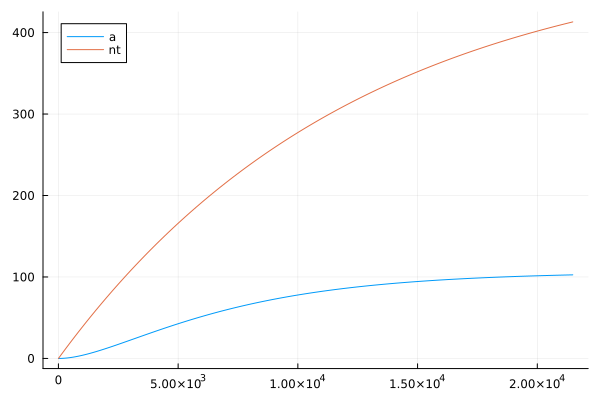

In [96]:
# Plot simulation.
plot(sol.t, transpose(sol[[a, nt],:]); labels=["a" "nt"])

## Making synthetic observations
As with the Turing.jl examples we can add noise to the ODE solutions to simulate a simple observation model.

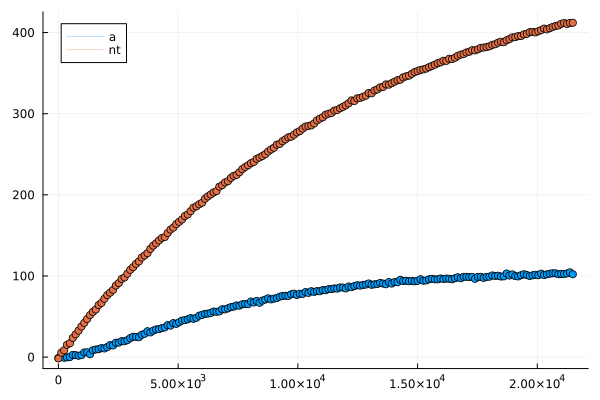

In [97]:
vars_to_use = [a, nt]
sol_all = solve(prob, Tsit5(); save_end=false, saveat=120.0)
sol_to_use = sol_all[vars_to_use, :]
odedata = Array(sol_to_use) .+ 0.8 .* randn(size(Array(sol_to_use)))

# Plot simulation and noisy observations.
plot(sol_all.t, transpose(sol_to_use); alpha=0.3, labels=["a" "nt"])
scatter!(sol_all.t, transpose(odedata); color=[1 2], label="")

## Fitting a model
There are two Turing.jl models: `fitmavelli` and `fitmavelli_arr`. `fitmavell_arr` is like `fitmavelli` but presents the `solve` method with an array rather than a map. It uses the `ModelingToolkit.varmap_to_vars()` call to ensure the values are in the correct order after the MT simplication process.

In [98]:
@model function fitmavelli(data, ode_prob, vars_to_use)

    # Noise for simulated observations
    #sigma ~ InverseGamma(2, 3)
    sigma_sq = 0.01
    epsilon = 0.000001

    # Prior distributions
    dk_TX ~ Uniform(1, 4)
    dk_TL ~ Uniform(0.03, 1.5)
    dk_RS ~ Uniform(6, 6.2)
    dk_EN ~ Uniform(90, 110)
    dK_RS_NTP ~ Uniform(190, 210)
    dK_EN_CP ~ Uniform(190, 210)
    dK_EN_NXP ~ Uniform(30, 50)
    dK_TL_nt ~ Uniform(220, 230)
    dK_TL_NTP ~ Uniform(5, 15)
    dK_RS_A ~ Uniform(18, 30)
    dK_RS_T ~ Uniform(0.2, 1.4)
    dK_TX_NTP ~ Uniform(70, 90)
    dk_nt_deg ~ Uniform(1e-05, 0.0001)
    dK_TX_DNA ~ Uniform(0.001, 10)
    dk_TL_deg ~ Uniform(1e-05, 0.001)
    dK_TL_AT ~ Uniform(5, 15)

    #p = [k_TX, k_TL, k_RS, k_EN, K_RS_NTP, K_EN_CP, K_EN_NXP, K_TL_nt, K_TL_NTP,
    #    K_RS_A, K_RS_T, K_TX_NTP, k_nt_deg, K_TX_DNA, k_TL_deg, K_TL_AT]
    params = Dict{Symbolics.Num, Float64}(
        k_TX => dk_TX, k_TL => dk_TL, k_RS => dk_RS,
        k_EN => dk_EN, k_nt_deg => dk_nt_deg, k_TL_deg => dk_TL_deg,
        K_TX_DNA => dK_TX_DNA, K_TX_NTP => dK_TX_NTP,
        K_TL_nt => dK_TL_nt, K_TL_AT => dK_TL_AT,
        K_TL_NTP => dK_TL_NTP, K_RS_A => dK_RS_A,
        K_RS_T => dK_RS_T, K_RS_NTP => dK_RS_NTP,
        K_EN_CP => dK_EN_CP, K_EN_NXP => dK_EN_NXP)

    predicted_sol = solve(ode_prob; p=params, save_end=false, saveat=120.0)
    predicted = predicted_sol[vars_to_use, :]
    
    # Observations.
    for i in 1:size(predicted,1)
        data[i, :] ~ MvNormal(predicted[i, :], sigma_sq * I)
    end

    return nothing
end

fitmavelli (generic function with 2 methods)

In [99]:
@model function fitmavelli_arr(data, ode_prob, vars_to_use)

    # Noise for simulated observations
    #sigma ~ InverseGamma(2, 3)
    sigma_sq = 0.01
    epsilon = 0.000001

    # Prior distributions
    dk_TX ~ Uniform(1, 4)
    dk_TL ~ Uniform(0.03, 1.5)
    dk_RS ~ Uniform(6, 6.2)
    dk_EN ~ Uniform(90, 110)
    dK_RS_NTP ~ Uniform(190, 210)
    dK_EN_CP ~ Uniform(190, 210)
    dK_EN_NXP ~ Uniform(30, 50)
    dK_TL_nt ~ Uniform(220, 230)
    dK_TL_NTP ~ Uniform(5, 15)
    dK_RS_A ~ Uniform(18, 30)
    dK_RS_T ~ Uniform(0.2, 1.4)
    dK_TX_NTP ~ Uniform(70, 90)
    dk_nt_deg ~ Uniform(1e-05, 0.0001)
    dK_TX_DNA ~ Uniform(0.001, 10)
    dk_TL_deg ~ Uniform(1e-05, 0.001)
    dK_TL_AT ~ Uniform(5, 15)

    #p = [k_TX, k_TL, k_RS, k_EN, K_RS_NTP, K_EN_CP, K_EN_NXP, K_TL_nt, K_TL_NTP,
    #    K_RS_A, K_RS_T, K_TX_NTP, k_nt_deg, K_TX_DNA, k_TL_deg, K_TL_AT]
    params = Dict{Symbolics.Num, Float64}(
        k_TX => dk_TX, k_TL => dk_TL, k_RS => dk_RS,
        k_EN => dk_EN, k_nt_deg => dk_nt_deg, k_TL_deg => dk_TL_deg,
        K_TX_DNA => dK_TX_DNA, K_TX_NTP => dK_TX_NTP,
        K_TL_nt => dK_TL_nt, K_TL_AT => dK_TL_AT,
        K_TL_NTP => dK_TL_NTP, K_RS_A => dK_RS_A,
        K_RS_T => dK_RS_T, K_RS_NTP => dK_RS_NTP,
        K_EN_CP => dK_EN_CP, K_EN_NXP => dK_EN_NXP)

    params_arr = ModelingToolkit.varmap_to_vars(params, parameters(mms_simp))
    new_ode = remake(ode_prob, p=params_arr)
    
    predicted_sol = solve(ode_prob; save_end=false, saveat=120.0)
    predicted = predicted_sol[vars_to_use, :]
    
    # Observations.
    for i in 1:size(predicted,1)
        data[i, :] ~ MvNormal(predicted[i, :], sigma_sq * I)
    end

    return nothing
end

fitmavelli_arr (generic function with 4 methods)

In [100]:
function make_data(ode_prob, vars_to_use::Vector{Symbolics.Num})
    soln_all_vars = solve(ode_prob, save_end=false, saveat=120.0)
    odedata = soln_all_vars[vars_to_use, :]
    odedatarand = odedata .+ (0.8 .* randn(size(odedata)))
    return odedata
end

make_data (generic function with 1 method)

### Make some data and create a model

In [101]:
ode_data = make_data(ode_prob, vars_to_use)

tspan = (1.0, 6 * 60 * 60)
ode_prob = ODEProblem(mms_simp, var_default_syms, tspan, param_default_syms)
model = fitmavelli_arr(ode_data, ode_prob, vars_to_use);

### Draw samples using the a model
The MH sampler succeeds but the NUTS sampler fails suggesting there is an issue with `AutoDiff`.

In [104]:
#sampler = NUTS(1000, 0.65)
sampler = MH()
n_samples, n_chains = 50, 1
chains = Turing.sample(model, sampler, MCMCSerial(), n_samples, n_chains; progress=false)

Chains MCMC chain (50×17×1 Array{Float64, 3}):

Iterations        = 1:1:50
Number of chains  = 1
Samples per chain = 50
Wall duration     = 1.25 seconds
Compute duration  = 1.25 seconds
parameters        = dk_TX, dk_TL, dk_RS, dk_EN, dK_RS_NTP, dK_EN_CP, dK_EN_NXP, dK_TL_nt, dK_TL_NTP, dK_RS_A, dK_RS_T, dK_TX_NTP, dk_nt_deg, dK_TX_DNA, dk_TL_deg, dK_TL_AT
internals         = lp

Summary Statistics
  parameters       mean       std   naive_se      mcse       ess      rhat   e ⋯
      Symbol    Float64   Float64    Float64   Float64   Float64   Float64     ⋯

       dk_TX     2.5818    0.8427     0.1192    0.0858   84.9485    0.9818     ⋯
       dk_TL     0.7799    0.4148     0.0587    0.0451   43.3464    1.0627     ⋯
       dk_RS     6.1003    0.0572     0.0081    0.0085   44.3422    0.9825     ⋯
       dk_EN   100.1413    5.4067     0.7646    0.6571   65.2043    0.9799     ⋯
   dK_RS_NTP   199.3621    5.5779     0.7888    0.7755   48.1487    1.0320     ⋯
    dK_EN_CP   200.4157    6.42

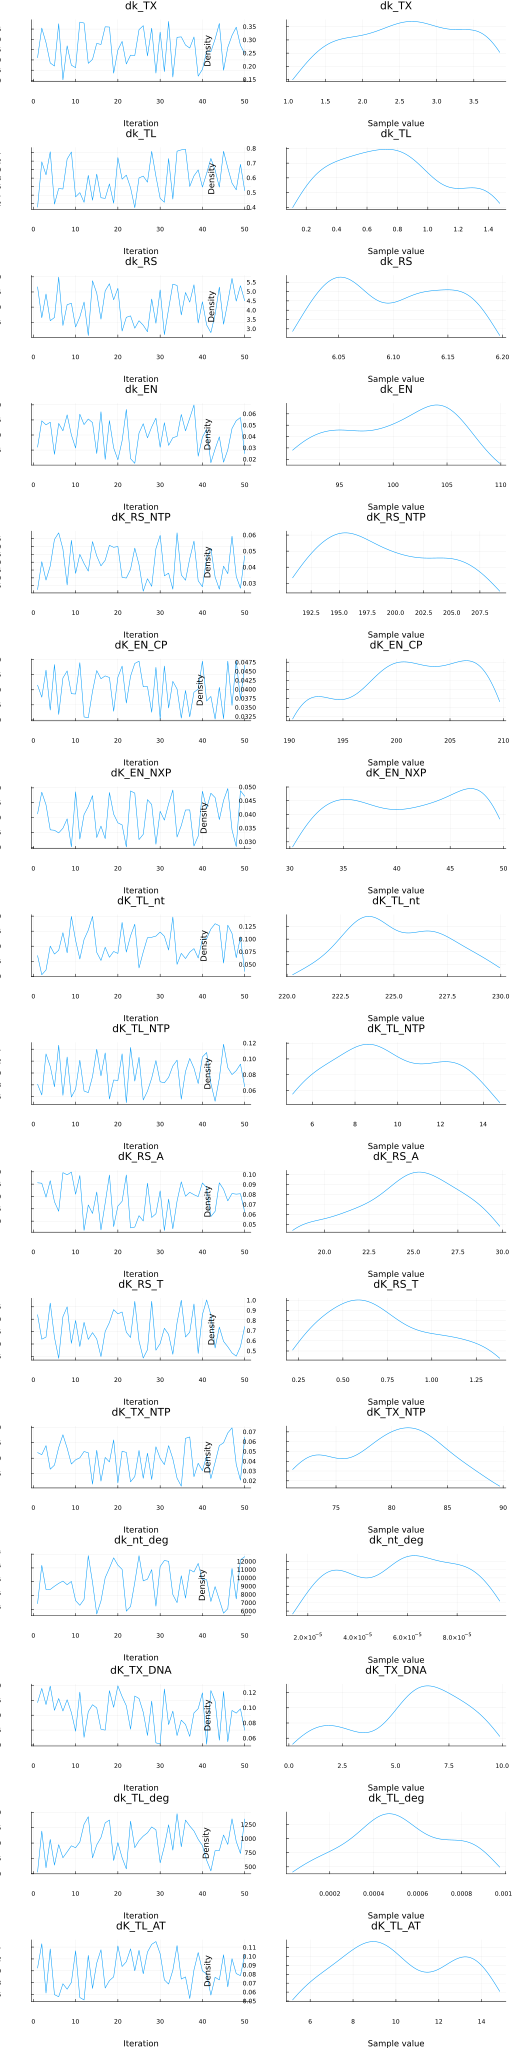

In [105]:
plot(chains)